# Grouping and reshaping data

We're going to look at some different ways of grouping and aggregating data. We're building towards thinking about 'split', 'apply', and 'combine workflows, which look something like this:

![split-apply-combine](https://github.com/core-skills/02-getting-to-know-the-tools/blob/master/notebooks/split-apply-combine.png?raw=true)

(taken from Jake VanderPlas' excellent [Python data science handbook](https://github.com/jakevdp/PythonDataScienceHandbook) - check out all the notebooks available on github if you want more in-depth examples than what we've worked through today).

## Groupby

Find the pandas `groupby` method and work out how it works. Use either your own data or the random dataframe generated below. If using your own data, try passing a categorical column from your data. 

For the random dataframe,

```python
import pandas
from numpy import inf
from random_data import random_dataframe

# Our faithful bogus dataframe
df = random_dataframe(30)
```

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

In [ ]:
# Install required packages if using jupyterhub
# %pip install -r ../requirements.txt

In [1]:
import pandas as pd
from numpy import inf
from random_data import random_dataframe

df = random_dataframe(30)
df.head()

,category,a,b
0,z,15.437279,0.191696
1,y,64.865292,0.418816
2,z,92.190810,0.572777
3,y,61.542078,0.822709
4,x,21.688553,0.150642


Next try to generate some summary statistics about each of your groups. The `info` and `describe` methods of the pandas dataframe are good places to start - try something like this:

```python
from random_data import random_dataframe

# Yet more bogus data
df = random_dataframe(100)

# Iterating in a for-loop
for category, grp_df in df.groupby('category'):
    print(f"\nInfo for group {category}")
    print(grp_df.describe())
```

In [2]:
from random_data import random_dataframe

# Yet more bogus data
df = random_dataframe(100)

# Iterating in a for-loop
for category, grp_df in df.groupby('category'):
    print(f"\nInfo for group {category}")
    print(grp_df.describe())


Info for group x
                a          b
count   25.000000  25.000000
mean    54.338560   0.446231
std     37.320106   0.259864
min    -33.442316   0.106748
25%     24.172881   0.192508
50%     57.561603   0.413735
75%     83.593896   0.651177
max    107.698607   0.915589

Info for group y
                a          b
count   40.000000  40.000000
mean    36.607761   0.437220
std     31.830922   0.298957
min     -9.747274   0.004649
25%      8.761959   0.201586
50%     30.091800   0.401079
75%     61.152735   0.692194
max    109.959675   0.981438

Info for group z
                a          b
count   35.000000  35.000000
mean    46.653767   0.486896
std     29.550570   0.318899
min     -9.813524   0.015275
25%     23.652409   0.221700
50%     50.287279   0.507987
75%     67.346742   0.787997
max    101.010923   0.998016


You don't have to iterate over the groups if you don't want to - you can pipeline them to an aggregating function directly (which is often easier to read).

```python
# Calculating an aggregation directly
df.groupby('category').sum()
```

Try looking at some of the other pandas aggregations: `count`, `first`, `last`, `mean`, `median`, `min`, `max`, `std`, `var`, `mad`, `prod`, `sum`. What do each of these do?

In [9]:
df.groupby('category').sum()
# df.groupby('category').mean()
# df.groupby('category').min()

,a,b
category,,
x,1358.464010,11.155777
y,1464.310429,17.488804
z,1632.881849,17.041360


In [14]:
# Just on one column
df.groupby('category')['a'].sum()

# Or to return a dataframe
# df.groupby('category', as_index=False)['a'].sum()

category
x    1358.464010
y    1464.310429
z    1632.881849
Name: a, dtype: float64

In [10]:
# Aggregation in multiple ways at the same time
df.groupby('category').agg(['sum','count'])

a                b      
                  sum count        sum count
category                                    
x         1358.464010    25  11.155777    25
y         1464.310429    40  17.488804    40
z         1632.881849    35  17.041360    35

Take a look at some of the more advanced group options - for example you can set a category as an index, and pass functions which take an index and output a group.

```python
# Calculating an aggregation by specifying a mapping 
# from index to group
mapping = {'x': 'first', 'y': 'first', 'z': 'second'}
df.set_index('category').groupby(mapping).mean()
```

How might you write a small function to start to aggregate or summarize the data in your data's groups in more complex ways?

In [47]:
mapping = {'x': 'first', 'y': 'first', 'z': 'second'}
df.set_index('category').groupby(mapping).mean()

/var/folders/mb/6nly2rd17jdg65dg27d237lw0000gn/T/ipykernel_59589/147236344.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.set_index('category').groupby(mapping).mean()


,a,b
category,,
first,50.522622,0.507624
second,49.717625,0.503443


In [20]:
def do_calc(df): 
    return pd.Series({'A_sum': df['a'].sum(), 'B_unique': len(df['b'].unique()) })

df.groupby('category').apply(do_calc).reset_index()
 
# # Another example    
# def calc_mean(dff):
#     return pd.Series([dff['a'].mean() + dff['b'].mean()])

# df.groupby('category').apply(calc_mean) 

,category,A_sum,B_unique
0,x,1358.464010,25.0
1,y,1464.310429,40.0
2,z,1632.881849,35.0


## Pivot table

Pivot tables are a lot like groupby operations but instead of ending up with one column of groups we can end up with multidimensional arrays of aggregations. 

In the diagram at the top of the page, you can think of a pivot table splitting the data using more than one column in the 'split' step.

This is generally more useful when we want to start to aggregate along multiple dimensions.

Using our example from above:

```python
import pandas
from numpy import inf
from random_data import random_dataframe

# Our faithful bogus dataframe
df = random_dataframe(3000, categories='uvwxyz')

# Add a new column which bins the a values
df['how_big'] = pandas.cut(df.a, 
                           bins=[-inf, 50, inf],
                           labels=('low', 'high'))

# make a new pivot table that calculates the mean for each
# of our subcategories - both 'x,y,z' and 'low' and 'high'
pivot = df.pivot_table('b', index='category', columns='how_big', aggfunc='mean')
```

`pandas.cut` can often be useful for investigating subsets of numerical data (e.g. ore grade in marginal blocks!).

In [23]:
import pandas
from numpy import inf
from random_data import random_dataframe

# Our faithful bogus dataframe
df = random_dataframe(3000, categories='uvwxyz')

# Add a new column which bins the a values
df['how_big'] = pandas.cut(df.a, 
                           bins=[-inf, 25, 50, 75, inf],
                           labels=('tiny', 'small', 'medium' 'large', 'huge'))

# make a new pivot table that calculates the mean for each
# of our subcategories - both 'x,y,z' and 'low' and 'high'
pivot = df.pivot_table('b', index='category', columns='how_big', aggfunc='sum')

In [24]:
pivot

how_big,tiny,small,mediumlarge,huge
category,,,,
u,52.375371,67.974509,57.502873,72.079294
v,54.520332,73.352697,49.983587,63.294391
w,63.368035,52.326728,65.330922,60.499755
x,67.491139,59.247777,60.399132,63.960619
y,59.614305,64.230901,63.403164,59.755379
z,62.119011,65.906811,59.179418,67.662995


In [20]:
df.groupby('how_big').count()

,category,a,b
how_big,,,
tiny,710,710,710
small,776,776,776
mediumlarge,744,744,744
huge,770,770,770


## Plotting data

Next we're going to use [seaborn](seaborn.pydata.org) to generate some pretty plots of our data. 

Most Python tutorials will introduce [matplotlib](https://matplotlib.org) at this stage because it's the default but seaborn is a much higher-level library with a nicer API, especially for exploratory vis (matplotlib will probably make more sense to you if you're coming from MATLAB world though). The only hangover is that we need to include the `%matplotlib inline` cell magic to tell Jupyter to render the graphics inline for us. 

We'll start by looking at our random dataset.  

In [26]:
import seaborn as sns
sns.set()

from random_data import random_dataframe

# Set up our dataframe and pivot table
df = random_dataframe(3000, categories='uvwxyz')
df['how_big'] = pandas.cut(df.a, 
                           bins=[-inf, 25, 50, 75, inf],
                           labels=('tiny', 'small', 'medium' 'large', 'huge'))
df.head()

,category,a,b,how_big
0,x,19.347329,0.812612,tiny
1,z,112.883934,0.220203,huge
2,u,64.445796,0.708031,mediumlarge
3,v,5.223673,0.977470,tiny
4,y,54.346605,0.787738,mediumlarge


For one-dimensional dataset we can try `seaborn.distplot`, `seaborn.kdeplot` and `seaborn.rugplot` to visualize the data.

In [61]:
# seaborn.set_context('talk') # paper, notebook, talk, poster
# seaborn.set_palette('colorblind') # deep, muted, pastel, bright, dark, and colorblind

/var/folders/mb/6nly2rd17jdg65dg27d237lw0000gn/T/ipykernel_95959/1964423193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.a)


<AxesSubplot: xlabel='a', ylabel='Density'>

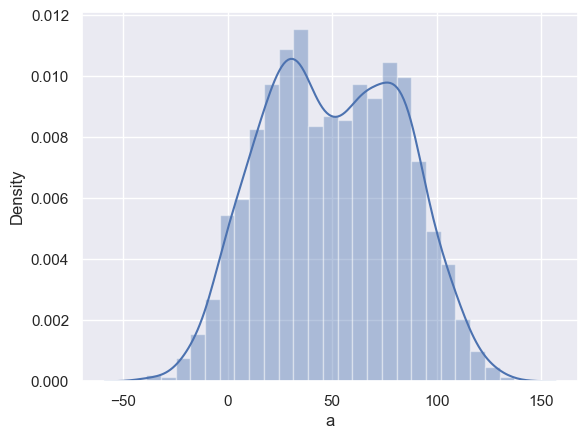

In [28]:
sns.distplot(df.a)

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.


<AxesSubplot: xlabel='a', ylabel='Density'>

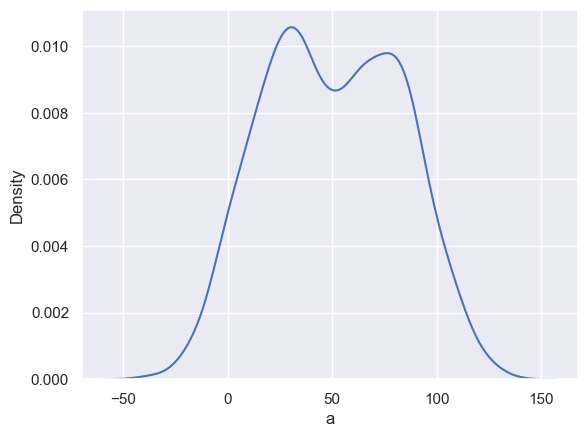

In [29]:
sns.kdeplot(df.a)

<AxesSubplot: >

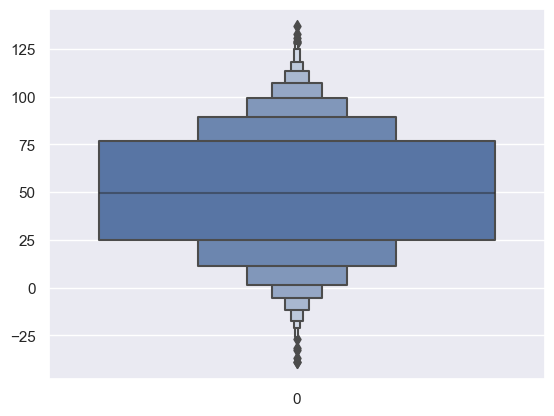

In [30]:
sns.boxenplot(df['a'])

<AxesSubplot: >

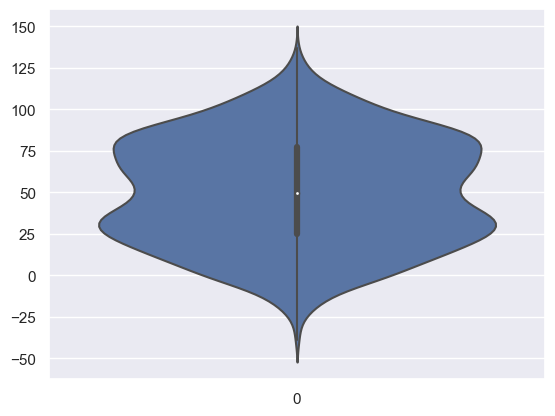

In [31]:
sns.violinplot(df['a'])

We can also use `jointplot` to generate a scatter and histograms of sets of data

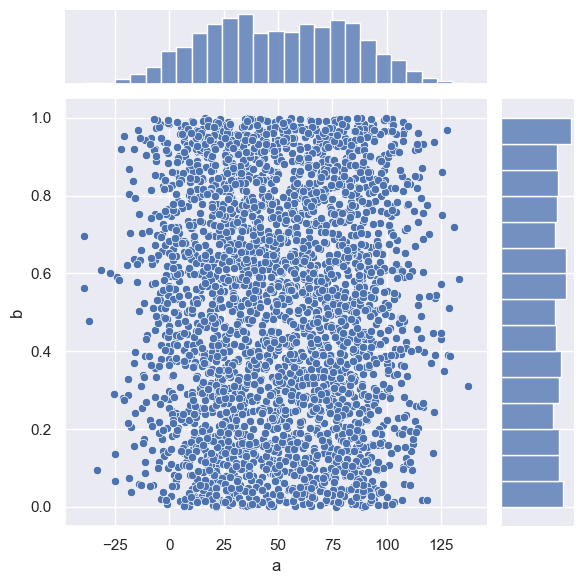

In [33]:
sns.jointplot(x='a', y='b', data=df)

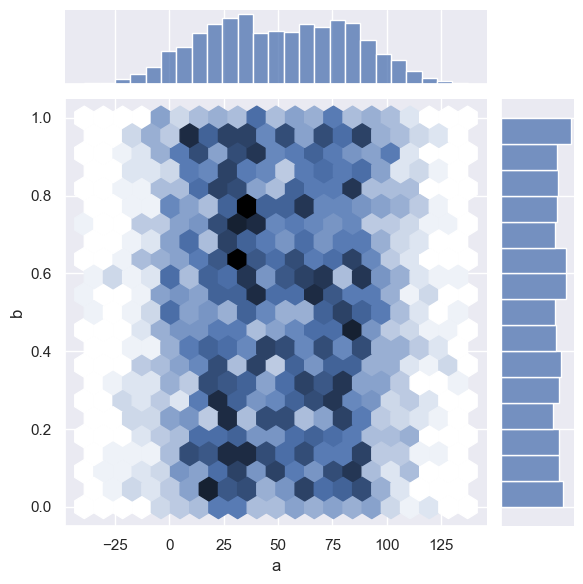

In [34]:
sns.jointplot(x='a', y='b', data=df, kind='hex')

For times when you want 'plot everything against everything else' you can do something like

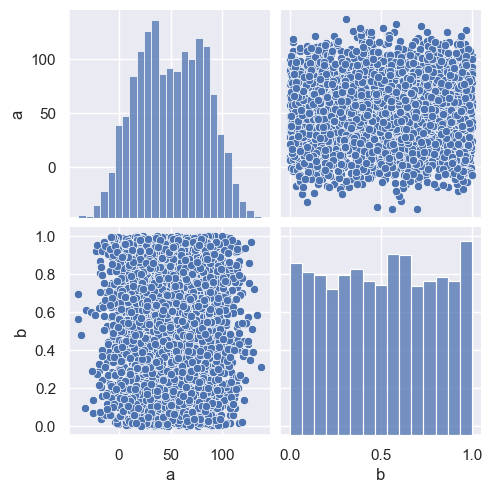

In [35]:
sns.pairplot(df)

This is really useful for pulling out relationships between variables

In [36]:
df['c'] = df.a + df.b * df.a
df['d'] = df.c * df.b + df.a

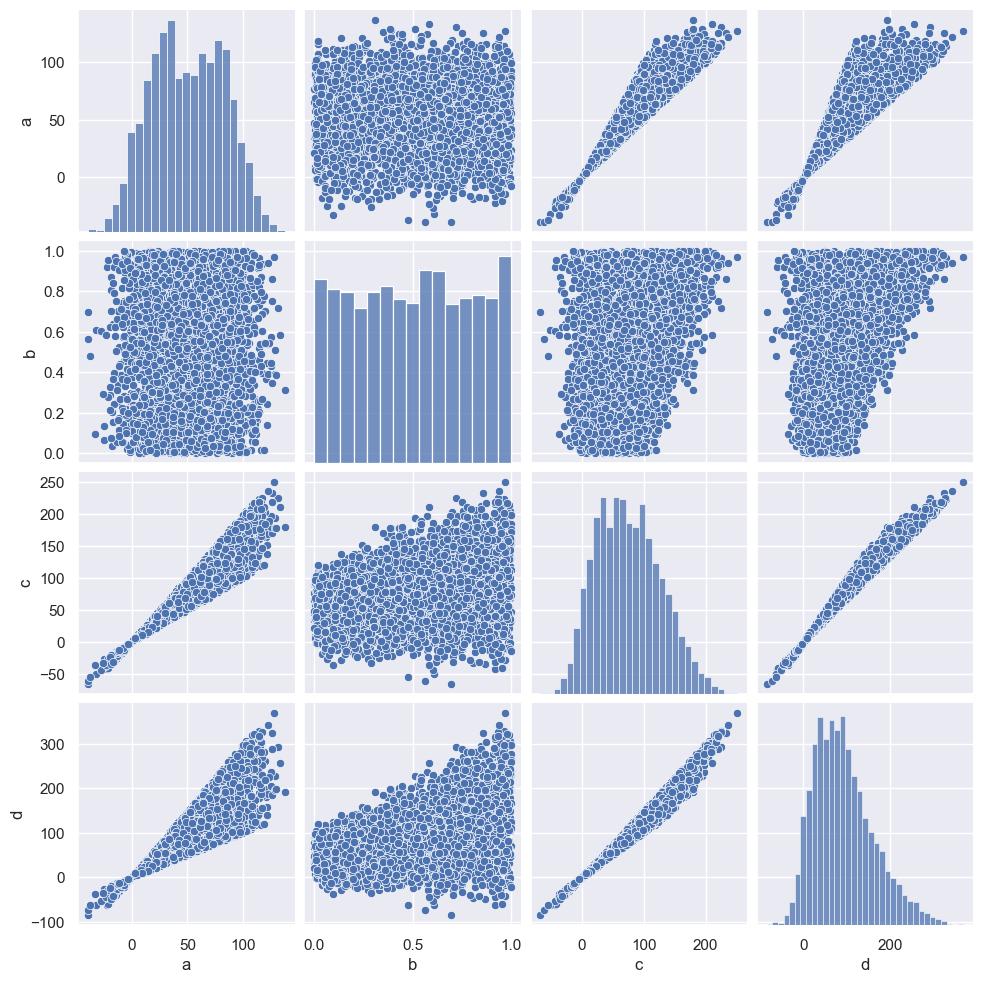

In [37]:
sns.pairplot(df)

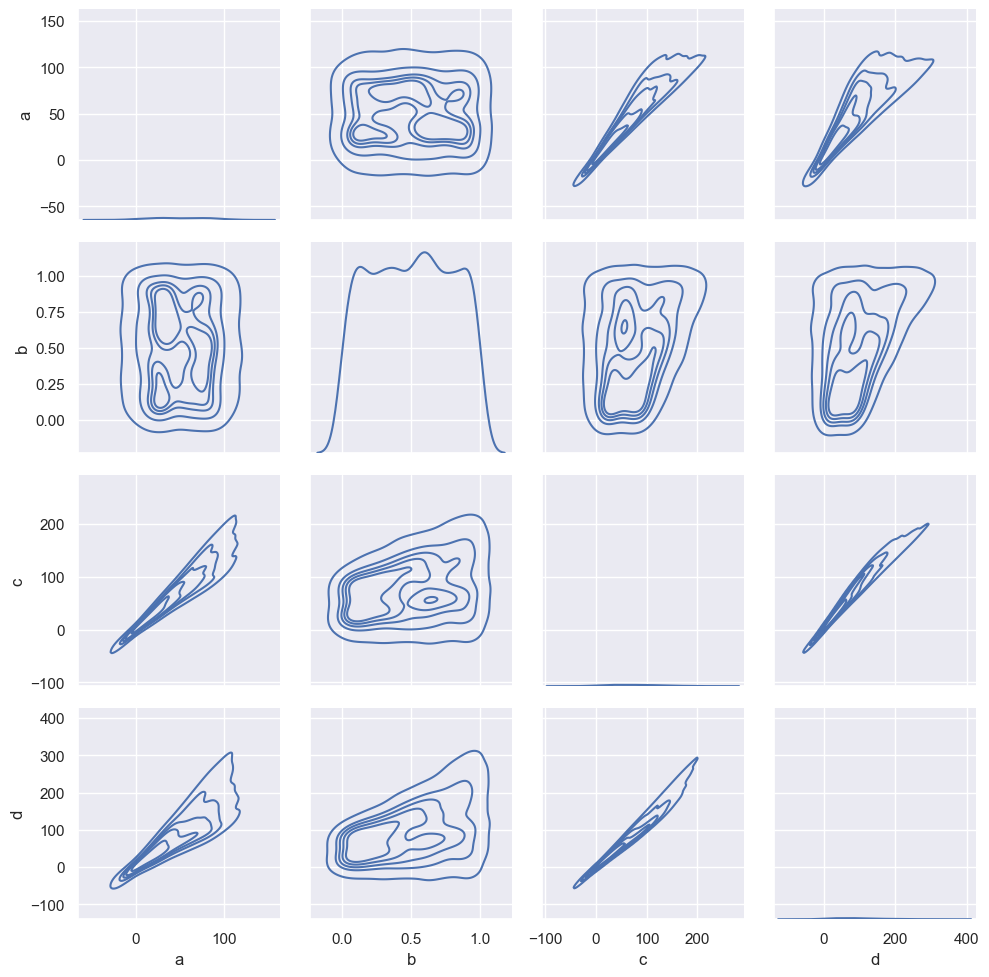

In [39]:
g = sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

Seaborn also has a heap of support for categorical data. We can also include more dimensions in the visualization by specifying further dimensions as colors or point size

<AxesSubplot: xlabel='a', ylabel='how_big'>

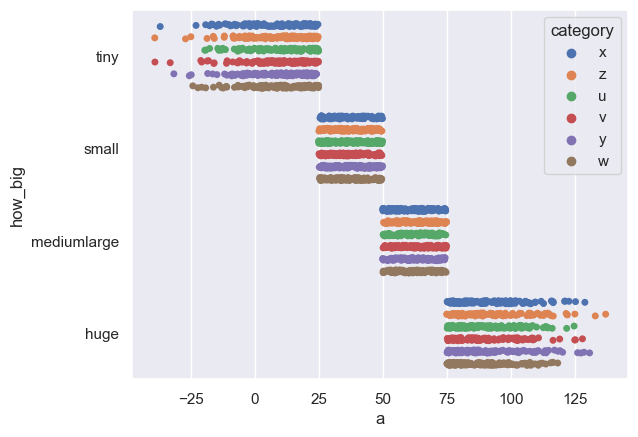

In [40]:
sns.stripplot(x='a', y='how_big', hue='category', data=df, jitter=True, dodge=True)

We can also visualize the pivot table we generated above with heatmaps. 

In [41]:
pivot = df.pivot_table('b', index='category', columns='how_big', aggfunc='sum')
pivot

how_big,tiny,small,mediumlarge,huge
category,,,,
u,60.423122,67.712516,50.636987,70.695292
v,59.408942,64.833945,53.212521,59.112295
w,73.104676,64.781755,66.389873,74.527641
x,57.291273,55.241631,64.075938,71.106830
y,69.499834,66.265251,50.732619,68.062991
z,60.322880,70.778638,53.978682,60.034020


<AxesSubplot: xlabel='how_big', ylabel='category'>

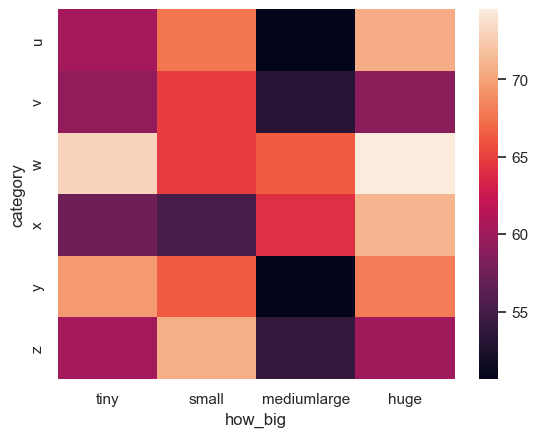

In [43]:
sns.heatmap(pivot)

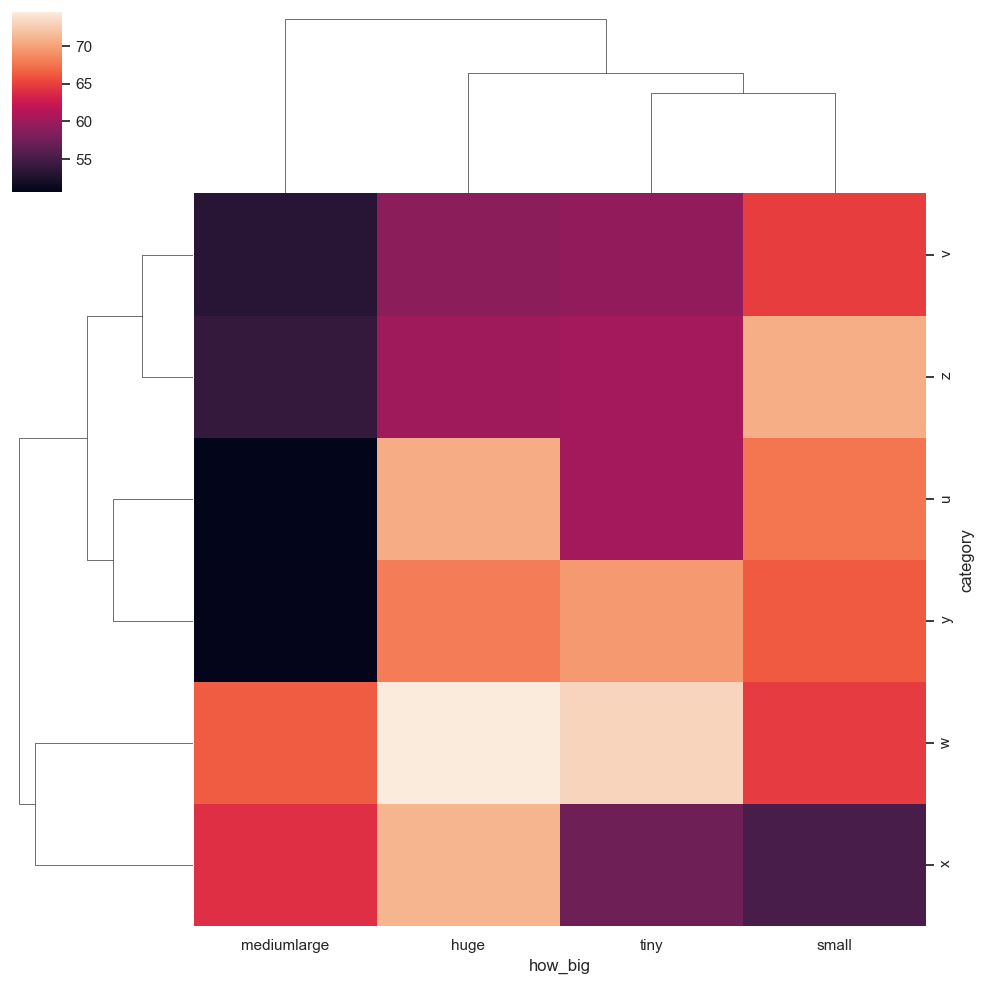

In [44]:
sns.clustermap(pivot)

Seaborn can get a lot more complicated than this and it's worth digging through the examples to find useful ways of slicing and dicing your dataframes into pictures.

Now try this out on your own dataset!